## Definición de la función objetivo y su gradiente

In [79]:
import numpy as np
# Definir la función objetivo y su gradiente
def f(x):
    x_clipped = np.clip(x, -100, 100)
    return (np.exp(x_clipped[0]) + np.exp(x_clipped[1])) * np.arctan(x_clipped[0]**2 + x_clipped[1]**2)

def grad_f(params):
    x, y = params
    # Limitar los valores para evitar overflow
    x_clipped = np.clip(x, -100, 100)
    y_clipped = np.clip(y, -100, 100)
    
    r = x_clipped**2 + y_clipped**2
    exp_x = np.exp(x_clipped)
    exp_y = np.exp(y_clipped)
    arctan_r = np.arctan(r)
    denom = 1 + r**2
    
    fx = exp_x * arctan_r + (exp_x + exp_y) * (2 * x_clipped) / denom
    fy = exp_y * arctan_r + (exp_x + exp_y) * (2 * y_clipped) / denom
    return np.array([fx, fy])


## Graficación de función objetivo

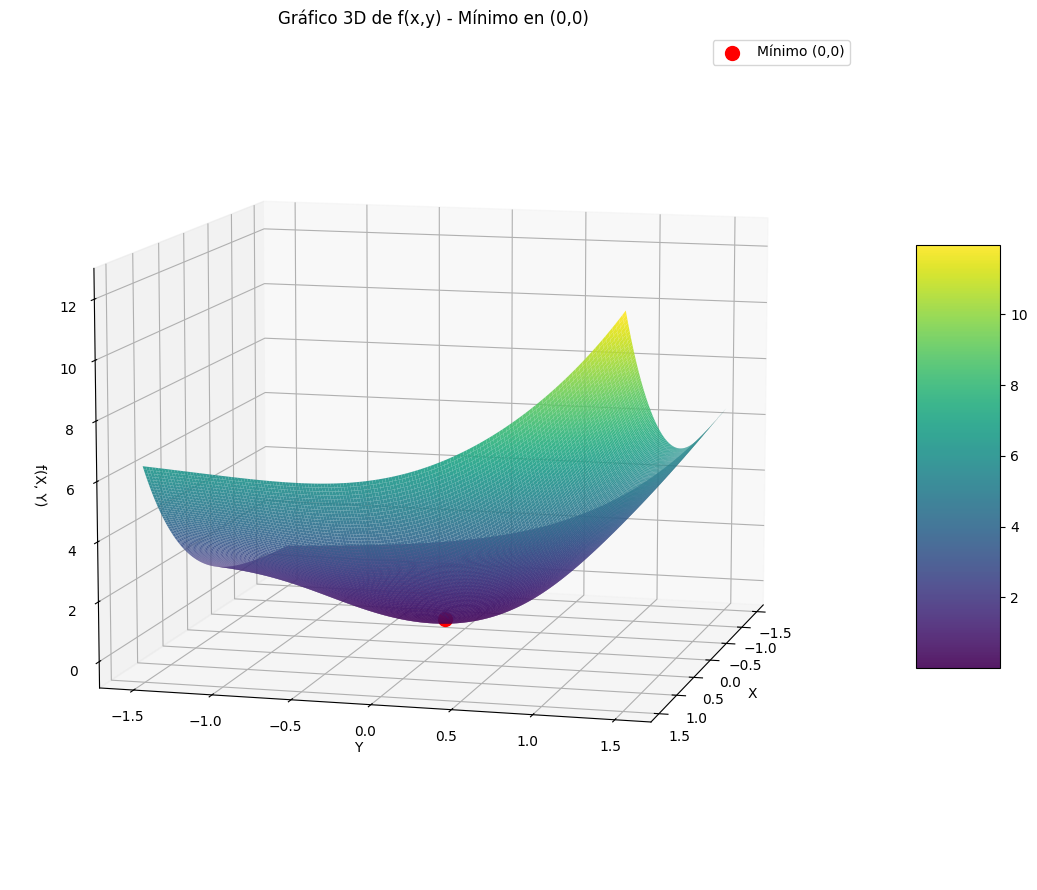

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Crear una malla de puntos más densa cerca del origen
x = np.linspace(-1.5, 1.5, 150)
y = np.linspace(-1.5, 1.5, 150)
X, Y = np.meshgrid(x, y)

# Evaluar la función en cada punto de la malla
Z = np.array([f([xi, yi]) for xi, yi in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

# Configurar el gráfico 3D
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Crear la superficie con colores que resalten el mínimo
surf = ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.9, 
                      linewidth=0, antialiased=True, rstride=1, cstride=1)

# Configurar el ángulo de vista para mostrar claramente el mínimo
ax.view_init(elev=10, azim=15)  # Elevación 10°, azimut 15°

# Etiquetas y título
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('f(X, Y)')
ax.set_title('Gráfico 3D de f(x,y) - Mínimo en (0,0)')

# Añadir barra de colores
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

# Añadir un punto rojo en el mínimo
ax.scatter([0], [0], [f([0,0])], color='red', s=100, label='Mínimo (0,0)')
ax.legend()

plt.tight_layout()
plt.show()


## Definición de métodos

In [81]:
from scipy.optimize import minimize
import numpy as np
def gradient_descent(x0, learning_rate=0.01, tol=1e-6, max_iter=10000, c=1e-4, beta=0.8):
    x = np.array(x0, dtype=float)
    history = [x.copy()]
    for _ in range(max_iter):
        grad = grad_f(x)
        x_new = x - learning_rate * grad
        history.append(x_new.copy())
        if np.linalg.norm(x_new - x) < tol:
            break
        x = x_new
    return x, history, len(history)

# Quasi-Newton usando scipy.optimize.minimize con BFGS y callback para historial
class Callback:
    def __init__(self):
        self.history = []
    def __call__(self, xk):
        self.history.append(np.array(xk))

def quasi_newton(x0, tolerance=1e-6, max_iterations=100):
    callback = Callback()
    result = minimize(
        f, x0, 
        method='BFGS', 
        jac=grad_f, 
        callback=callback,
        options={
            'gtol': tolerance,
            'disp': False, 
            'maxiter': max_iterations
        })
    return result, [np.array(x0)] + callback.history, len(callback.history)

## Implementación de metodos de graficación

In [82]:
# Función graficar_comparativo_resultados
def graficar_comparativo_resultados(resultados_completos):
    """Genera gráficos comparativos de todos los resultados con histograma de iteraciones"""
    resultados = resultados_completos['resultados']
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Subgráfico 1: HISTOGRAMA de iteraciones por rangos
    iter_qn = [r['quasi_newton']['iteraciones'] for r in resultados]
    iter_gd = [r['descenso_gradiente']['iteraciones'] for r in resultados]
    
    # Definir rangos para el histograma
    max_iter = max(max(iter_qn), max(iter_gd))
    if max_iter <= 10:
        bins = np.arange(0, 12, 1)
    elif max_iter <= 50:
        bins = np.arange(0, 55, 5)
    elif max_iter <= 100:
        bins = np.arange(0, 110, 10)
    else:
        bins = np.arange(0, max_iter + 20, 20)
    
    ax1.hist(iter_qn, bins=bins, alpha=0.7, label='Quasi-Newton', color='blue', edgecolor='black', rwidth=0.8)
    ax1.hist(iter_gd, bins=bins, alpha=0.7, label='Descenso Gradiente', color='red', edgecolor='black', rwidth=0.8)
    ax1.set_xlabel('Rango de Iteraciones')
    ax1.set_ylabel('Cantidad de Casos')
    ax1.set_title('Distribución de Iteraciones por Método\n(Agrupado por Rangos)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Subgráfico 2: Valor final de la función
    val_qn = [r['quasi_newton']['valor_final'] for r in resultados]
    val_gd = [r['descenso_gradiente']['valor_final'] for r in resultados]

    # Usar números de caso en lugar de nombres
    n_casos = len(resultados)
    casos_numeros = list(range(1, n_casos + 1))

    ax2.semilogy(casos_numeros, val_qn, 'o-', label='Quasi-Newton', linewidth=2, markersize=8)
    ax2.semilogy(casos_numeros, val_gd, 's-', label='Descenso Gradiente', linewidth=2, markersize=8)

    # Añadir línea divisoria entre casos cercanos y lejanos (después del caso 16)
    if n_casos > 16:
        ax2.axvline(x=16.5, color='red', linestyle='--', alpha=0.7, linewidth=2)
        # Añadir etiquetas para identificar las regiones
        ax2.text(8, ax2.get_ylim()[1] * 0.9, 'Casos Cercanos', 
                ha='center', va='center', fontsize=10, color='red', weight='bold',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
        ax2.text(24, ax2.get_ylim()[1] * 0.9, 'Casos Lejanos', 
                ha='center', va='center', fontsize=10, color='red', weight='bold',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    ax2.set_xlabel('Número del Caso')
    ax2.set_ylabel('Valor Final f(x) (escala log)')
    ax2.set_title('Comparación del Valor Final de la Función\n')
    ax2.set_xticks(casos_numeros)
    ax2.set_xticklabels([str(i) for i in casos_numeros])
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Subgráfico 3: Eficiencia relativa
    eficiencia = [iter_gd[i]/max(iter_qn[i], 1) for i in range(len(iter_qn))]
    
    ax3.bar(casos_numeros, eficiencia, alpha=0.7, color='orange', edgecolor='black')
    ax3.axhline(y=1, color='red', linestyle='--', label='Límite igualdad', linewidth=2)
    ax3.set_xlabel('Número del Caso')
    ax3.set_ylabel('Iteraciones GD / Iteraciones QN')
    ax3.set_title('Eficiencia Relativa: GD vs QN\n(Valores >1 indican más iteraciones en GD)')
    ax3.set_xticks(casos_numeros)
    ax3.set_xticklabels([str(i) for i in casos_numeros])
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Subgráfico 4: Resumen estadístico
    metodos = ['Quasi-Newton', 'Descenso Gradiente']
    iter_promedio = [
        resultados_completos['resumen_estadisticas']['quasi_newton']['iteraciones_promedio'],
        resultados_completos['resumen_estadisticas']['descenso_gradiente']['iteraciones_promedio']
    ]
    
    barras = ax4.bar(metodos, iter_promedio, alpha=0.7, color=['blue', 'red'], edgecolor='black')
    ax4.set_ylabel('Iteraciones Promedio')
    ax4.set_title('Resumen de Iteraciones Promedio\n(Todos los casos)')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def calcular_limites_automaticos(gd_history, qn_history, margen=0.2):
    """
    Calcula límites automáticos basados en las trayectorias con mejor manejo de casos extremos
    """
    # Convertir a arrays numpy
    gd_array = np.array(gd_history)
    qn_array = np.array(qn_history)
    all_points = np.vstack([gd_array, qn_array])
    
    x_min, x_max = all_points[:, 0].min(), all_points[:, 0].max()
    y_min, y_max = all_points[:, 1].min(), all_points[:, 1].max()
    
    # Si todos los puntos están muy cerca, usar límites por defecto
    if abs(x_max - x_min) < 1e-10 and abs(y_max - y_min) < 1e-10:
        x_lim = (x_min - 2, x_max + 2)
        y_lim = (y_min - 2, y_max + 2)
    else:
        # Añadir margen proporcional al rango
        x_range = x_max - x_min
        y_range = y_max - y_min
        
        # Margen mínimo de 0.5 para evitar límites demasiado estrechos
        x_margin = max(x_range * margen, 0.5)
        y_margin = max(y_range * margen, 0.5)
        
        x_lim = (x_min - x_margin, x_max + x_margin)
        y_lim = (y_min - y_margin, y_max + y_margin)
    
    # Limitar los límites a un rango razonable para evitar problemas numéricos
    max_limit = 1000  # Límite máximo para evitar problemas de memoria
    x_lim = (max(x_lim[0], -max_limit), min(x_lim[1], max_limit))
    y_lim = (max(y_lim[0], -max_limit), min(y_lim[1], max_limit))
    
    return x_lim, y_lim

def graficar_trayectorias_contorno(gd_history, qn_history, caso_nombre, f, x_lim=None, y_lim=None):
    """
    Grafica las trayectorias de optimización en el espacio de búsqueda 2D
    
    Args:
        gd_history: Lista de puntos del descenso por gradiente
        qn_history: Lista de puntos del quasi-Newton
        caso_nombre: Nombre del caso para el título
        f: Función objetivo
        x_lim: Límites del eje x (None para automático)
        y_lim: Límites del eje y (None para automático)
    """
    
    # Convertir historiales a arrays
    gd_array = np.array(gd_history)
    qn_array = np.array(qn_history)
    
    # Calcular límites automáticos si no se proporcionan
    if x_lim is None or y_lim is None:
        x_lim_auto, y_lim_auto = calcular_limites_automaticos(gd_history, qn_history)
        x_lim = x_lim if x_lim is not None else x_lim_auto
        y_lim = y_lim if y_lim is not None else y_lim_auto
    
    # Crear malla para el contorno
    x = np.linspace(x_lim[0], x_lim[1], 100)
    y = np.linspace(y_lim[0], y_lim[1], 100)
    X, Y = np.meshgrid(x, y)
    
    # Evaluar la función en la malla (manejar posibles errores)
    try:
        Z = np.array([f([xi, yi]) for xi, yi in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)
    except Exception as e:
        print(f"Error evaluando la función: {e}")
        # Usar una función por defecto si falla
        Z = X**2 + Y**2
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Gráfico de contorno con trayectorias
    try:
        contour = ax1.contour(X, Y, Z, levels=20, alpha=0.6)
        ax1.clabel(contour, inline=True, fontsize=8)
        ax1.contourf(X, Y, Z, levels=50, alpha=0.3, cmap='viridis')
    except Exception as e:
        print(f"Error creando contornos: {e}")
    
    # Trayectoria Descenso por Gradiente
    ax1.plot(gd_array[:, 0], gd_array[:, 1], 'ro-', linewidth=2, markersize=4, 
             label='Descenso Gradiente', alpha=0.7)
    ax1.scatter(gd_array[0, 0], gd_array[0, 1], color='green', s=100, 
                label='Inicio', zorder=5)
    ax1.scatter(gd_array[-1, 0], gd_array[-1, 1], color='red', s=100, 
                label='Fin GD', zorder=5)
    
    # Trayectoria Quasi-Newton
    ax1.plot(qn_array[:, 0], qn_array[:, 1], 'bo-', linewidth=2, markersize=4, 
             label='Quasi-Newton', alpha=0.7)
    ax1.scatter(qn_array[-1, 0], qn_array[-1, 1], color='blue', s=100, 
                label='Fin QN', zorder=5)
    
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_title(f'Trayectorias de Optimización - {caso_nombre}')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(x_lim)
    ax1.set_ylim(y_lim)
    
    # Gráfico de convergencia
    ax2.semilogy(range(len(gd_history)), [f(p) for p in gd_history], 
                 'ro-', label='Descenso Gradiente', alpha=0.7)
    ax2.semilogy(range(len(qn_history)), [f(p) for p in qn_history], 
                 'bo-', label='Quasi-Newton', alpha=0.7)
    ax2.set_xlabel('Iteración')
    ax2.set_ylabel('Valor f(x) (escala log)')
    ax2.set_title(f'Convergencia - {caso_nombre}')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def graficar_trayectorias_3d(gd_history, qn_history, caso_nombre, f, x_lim=None, y_lim=None):
    """
    Grafica las trayectorias en 3D sobre la superficie de la función
    """
    # Convertir historiales a arrays
    gd_array = np.array(gd_history)
    qn_array = np.array(qn_history)
    
    # Calcular límites automáticos si no se proporcionan
    if x_lim is None or y_lim is None:
        x_lim, y_lim = calcular_limites_automaticos(gd_history, qn_history, margen=0.3)
    
    # Verificar si los límites son muy grandes y ajustar la resolución
    x_range = x_lim[1] - x_lim[0]
    y_range = y_lim[1] - y_lim[0]
    
    # Ajustar resolución basada en el rango
    if max(x_range, y_range) > 50:
        resolution = 30  # Baja resolución para rangos grandes
    elif max(x_range, y_range) > 20:
        resolution = 50  # Resolución media
    else:
        resolution = 80  # Alta resolución para rangos pequeños
    
    print(f"   📐 Resolución 3D: {resolution}x{resolution} para rango X: {x_range:.2f}, Y: {y_range:.2f}")
    
    # Crear malla
    x = np.linspace(x_lim[0], x_lim[1], resolution)
    y = np.linspace(y_lim[0], y_lim[1], resolution)
    X, Y = np.meshgrid(x, y)
    
    # Evaluar la función en la malla con manejo de errores robusto
    try:
        # Vectorizar la evaluación si es posible
        Z = np.zeros_like(X)
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                try:
                    Z[i, j] = f([X[i, j], Y[i, j]])
                except:
                    Z[i, j] = 0  # Valor por defecto en caso de error
    except Exception as e:
        print(f"   ⚠️  Error evaluando función 3D: {e}")
        # Crear una superficie simple como fallback
        Z = X**2 + Y**2
    
    # Calcular valores Z para las trayectorias
    try:
        gd_z = [f(p) for p in gd_history]
        qn_z = [f(p) for p in qn_history]
    except:
        # Fallback para trayectorias
        gd_z = [p[0]**2 + p[1]**2 if len(p) > 1 else 0 for p in gd_history]
        qn_z = [p[0]**2 + p[1]**2 if len(p) > 1 else 0 for p in qn_history]
    
    fig = plt.figure(figsize=(16, 7))
    
    # Vista 3D 1 - Perspectiva estándar
    ax1 = fig.add_subplot(121, projection='3d')
    try:
        # Usar plot_surface con parámetros optimizados
        surf1 = ax1.plot_surface(X, Y, Z, cmap='viridis', alpha=0.7, 
                                linewidth=0, antialiased=True, rstride=1, cstride=1)
        
        # Añadir barra de color
        fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=20, label='f(x,y)')
    except Exception as e:
        print(f"   ⚠️  Error creando superficie 3D: {e}")
    
    # Trayectorias con mejor visibilidad
    ax1.plot(gd_array[:, 0], gd_array[:, 1], gd_z, 'ro-', linewidth=3, 
             label='Descenso Gradiente', markersize=6, alpha=0.8)
    ax1.plot(qn_array[:, 0], qn_array[:, 1], qn_z, 'bo-', linewidth=3, 
             label='Quasi-Newton', markersize=6, alpha=0.8)
    
    # Puntos inicial y final
    ax1.scatter([gd_array[0, 0]], [gd_array[0, 1]], [gd_z[0]], 
                color='green', s=200, label='Inicio', marker='*')
    ax1.scatter([gd_array[-1, 0]], [gd_array[-1, 1]], [gd_z[-1]], 
                color='red', s=150, label='Fin GD', marker='s')
    ax1.scatter([qn_array[-1, 0]], [qn_array[-1, 1]], [qn_z[-1]], 
                color='blue', s=150, label='Fin QN', marker='^')
    
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('f(X, Y)')
    ax1.set_title(f'Trayectorias 3D - {caso_nombre}\nRango: X[{x_lim[0]:.1f},{x_lim[1]:.1f}] Y[{y_lim[0]:.1f},{y_lim[1]:.1f}]')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Vista 3D 2 - Perspectiva aérea
    ax2 = fig.add_subplot(122, projection='3d')
    try:
        surf2 = ax2.plot_surface(X, Y, Z, cmap='viridis', alpha=0.7, 
                                linewidth=0, antialiased=True, rstride=1, cstride=1)
        fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=20, label='f(x,y)')
    except Exception as e:
        print(f"   ⚠️  Error creando superficie 3D (vista 2): {e}")
    
    # Mismas trayectorias
    ax2.plot(gd_array[:, 0], gd_array[:, 1], gd_z, 'ro-', linewidth=3, 
             label='Descenso Gradiente', markersize=6, alpha=0.8)
    ax2.plot(qn_array[:, 0], qn_array[:, 1], qn_z, 'bo-', linewidth=3, 
             label='Quasi-Newton', markersize=6, alpha=0.8)
    
    # Puntos
    ax2.scatter([gd_array[0, 0]], [gd_array[0, 1]], [gd_z[0]], 
                color='green', s=200, label='Inicio', marker='*')
    ax2.scatter([gd_array[-1, 0]], [gd_array[-1, 1]], [gd_z[-1]], 
                color='red', s=150, label='Fin GD', marker='s')
    ax2.scatter([qn_array[-1, 0]], [qn_array[-1, 1]], [qn_z[-1]], 
                color='blue', s=150, label='Fin QN', marker='^')
    
    # Vista desde arriba
    ax2.view_init(elev=80, azim=-90)  # Vista aérea
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('f(X, Y)')
    ax2.set_title(f'Vista Aérea - {caso_nombre}')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    
def visualizar_caso_completo(gd_history, qn_history, case_name):
    """
    Visualiza un caso específico con todos los gráficos
    """
    # Calcular límites automáticos
    x_lim, y_lim = calcular_limites_automaticos(gd_history, qn_history, margen=0.3)
    
    # Graficar
    graficar_trayectorias_contorno(gd_history, qn_history, case_name, f, x_lim, y_lim)
    graficar_trayectorias_3d(gd_history, qn_history, case_name, f, x_lim, y_lim)

## Ejecución de experimentos

In [83]:
import json
import numpy as np
from datetime import datetime

def ejecutar_experimentos(archivo_json: str, archivo_salida: str = "resultados_experimentos.json", mostrar_graficos_individuales = True,max_casos_graficos = 2):
    """
    Carga casos de prueba desde un archivo JSON, ejecuta los experimentos
    y guarda los resultados en otro archivo JSON.
    
    Args:
        archivo_json: Ruta del archivo JSON con los casos de prueba
        archivo_salida: Ruta del archivo JSON donde se guardarán los resultados
        mostrar_graficos_individuales: Si es True, genera gráficos individuales para cada caso
        max_casos_graficos: Número máximo de casos para los que se generarán gráficos individuales
                            (por defecto 2, solo los dos primeros casos)
    """
    print("INICIANDO EXPERIMENTACIÓN")
    print("=" * 60)
    
    # Cargar datos desde JSON
    try:
        with open(archivo_json, 'r', encoding='utf-8') as file:
            datos = json.load(file)
        
        casos_prueba = datos.get("casos_prueba", [])
        
    except FileNotFoundError:
        print(f"Error: Archivo {archivo_json} no encontrado")
        return
    except json.JSONDecodeError:
        print(f"Error: Archivo {archivo_json} no es un JSON válido")
        return
   
    resultados_totales = []
    historiales_completos = {}
    
    # Ejecutar cada caso de prueba 
    for i, caso in enumerate(casos_prueba, 1):        
        # Convertir a numpy array
        x0 = np.array(caso['x0'])
        
        # Ejecutar Quasi-Newton
        qn_result, qn_history, qn_iter = quasi_newton(x0, caso['tolerance'], caso['max_iterations'])
               
        # Ejecutar Descenso por Gradiente
        gd_optimo, gd_history, gd_iter = gradient_descent(
            x0, learning_rate= caso['learning_rate'], 
            tol = caso['tolerance'], max_iter= caso['max_iterations']
        )
        
        # Almacenar resultados
        resultado_caso = {
            'nombre': caso.get('name', f'Caso {i}'),
            'punto_inicial': caso['x0'],
            'parametros': {
                'learning_rate': float(caso['learning_rate']),
                'tolerance': float(caso['tolerance']),
                'max_iterations': int(caso['max_iterations'])
            },
            'quasi_newton': {
                'optimo': qn_result.x.tolist() if hasattr(qn_result, 'x') else qn_result.tolist(),
                'iteraciones': int(qn_iter),
                'valor_final': float(f(qn_result.x if hasattr(qn_result, 'x') else qn_result))
            },
            'descenso_gradiente': {
                'optimo': gd_optimo.tolist(),
                'iteraciones': int(gd_iter),
                'valor_final': float(f(gd_optimo))
            }
        }
        
        resultados_totales.append(resultado_caso)

        # Guardar historiales para graficar
        historiales_completos[f'Caso_{i}'] = {
            'nombre': caso.get('name', f'Caso {i}'),
            'gd_history': gd_history,
            'qn_history': qn_history,
            'punto_inicial': caso['x0']
        }
        
        # Mostrar gráficos individuales si está activado
        if mostrar_graficos_individuales and i <= max_casos_graficos:
            visualizar_caso_completo(gd_history,qn_history,f"Caso {i}")
    
    # Crear estructura completa de resultados
    resultados_completos = {
        'metadata': {
            'fecha_ejecucion': datetime.now().isoformat(),
            'total_casos': len(resultados_totales),
            'funcion_objetivo': 'f(x,y) = (eˣ + eʸ) arctan(x² + y²)' 
        },
        'resultados': resultados_totales,
        'resumen_estadisticas': {
            'quasi_newton': {
                'iteraciones_promedio': float(np.mean([r['quasi_newton']['iteraciones'] for r in resultados_totales])),
                'valor_promedio': float(np.mean([r['quasi_newton']['valor_final'] for r in resultados_totales])),
                'iteraciones_totales': int(sum([r['quasi_newton']['iteraciones'] for r in resultados_totales]))
            },
            'descenso_gradiente': {
                'iteraciones_promedio': float(np.mean([r['descenso_gradiente']['iteraciones'] for r in resultados_totales])),
                'valor_promedio': float(np.mean([r['descenso_gradiente']['valor_final'] for r in resultados_totales])),
                'iteraciones_totales': int(sum([r['descenso_gradiente']['iteraciones'] for r in resultados_totales]))
            }
        }
    }
    
    # Guardar resultados en archivo JSON
    try:
        with open(archivo_salida, 'w', encoding='utf-8') as file:
            json.dump(resultados_completos, file, indent=2, ensure_ascii=False)
        
        print(f"\n{'='*60}")
        print("✅ RESULTADOS GUARDADOS EXITOSAMENTE")
        print(f"{'='*60}")
        print(f"Archivo: {archivo_salida}")
        
    except Exception as e:
        print(f"Error al guardar los resultados: {e}")
        return None
    
    # Mostrar gráfico comparativo final
    print(f"\n📈 GENERANDO GRÁFICOS COMPARATIVOS FINALES...")
    graficar_comparativo_resultados(resultados_completos)
    return resultados_completos, historiales_completos

INICIANDO EXPERIMENTACIÓN


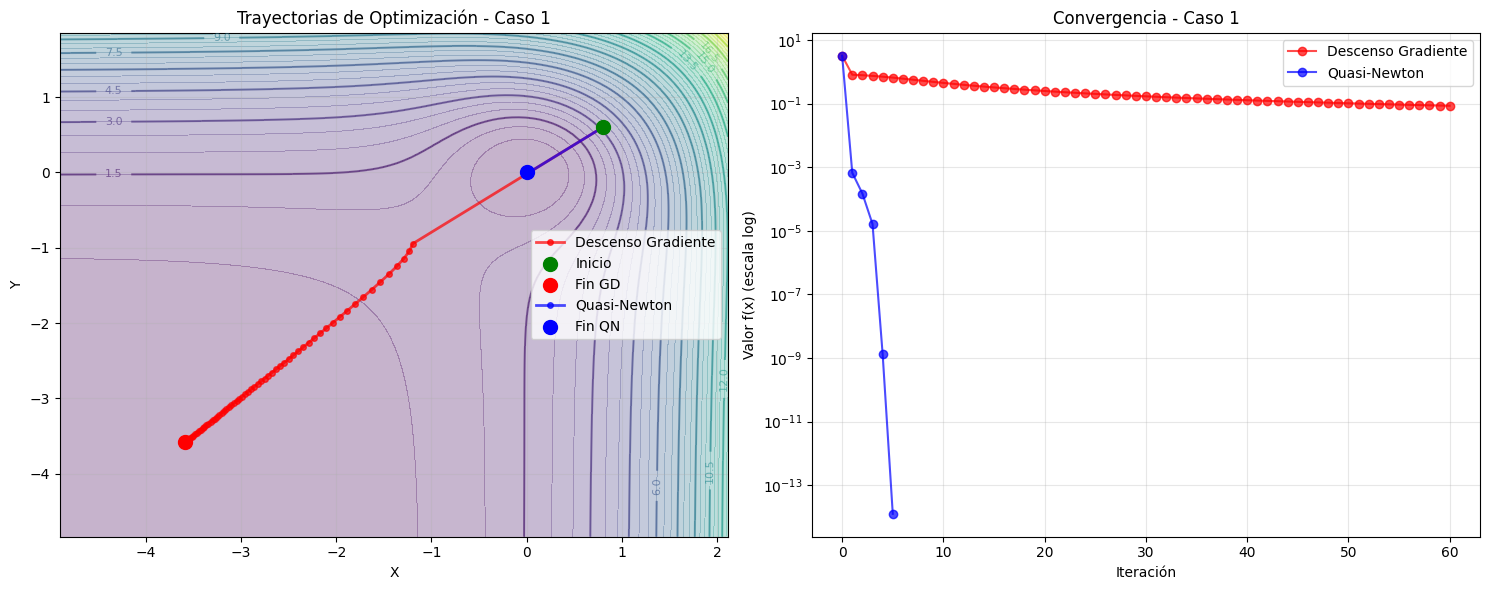

   📐 Resolución 3D: 80x80 para rango X: 7.02, Y: 6.69


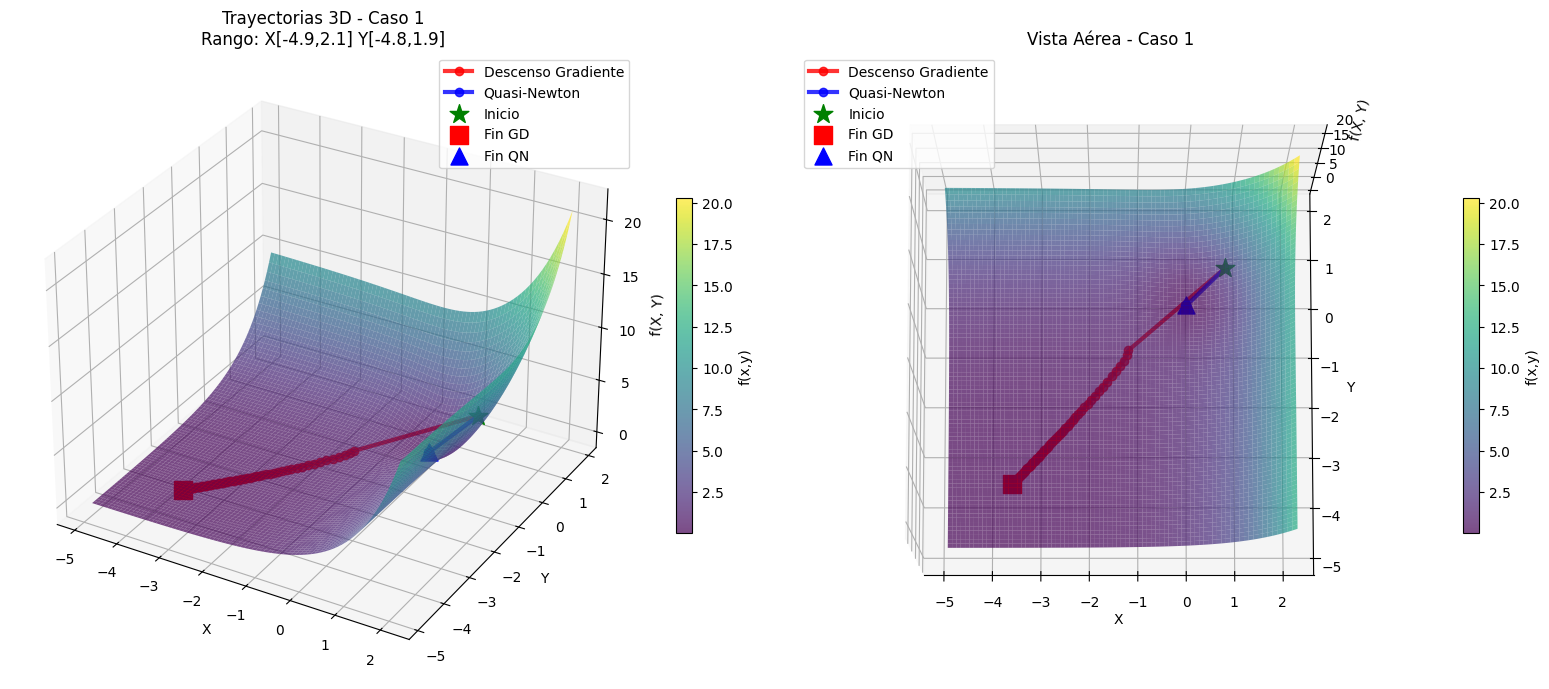

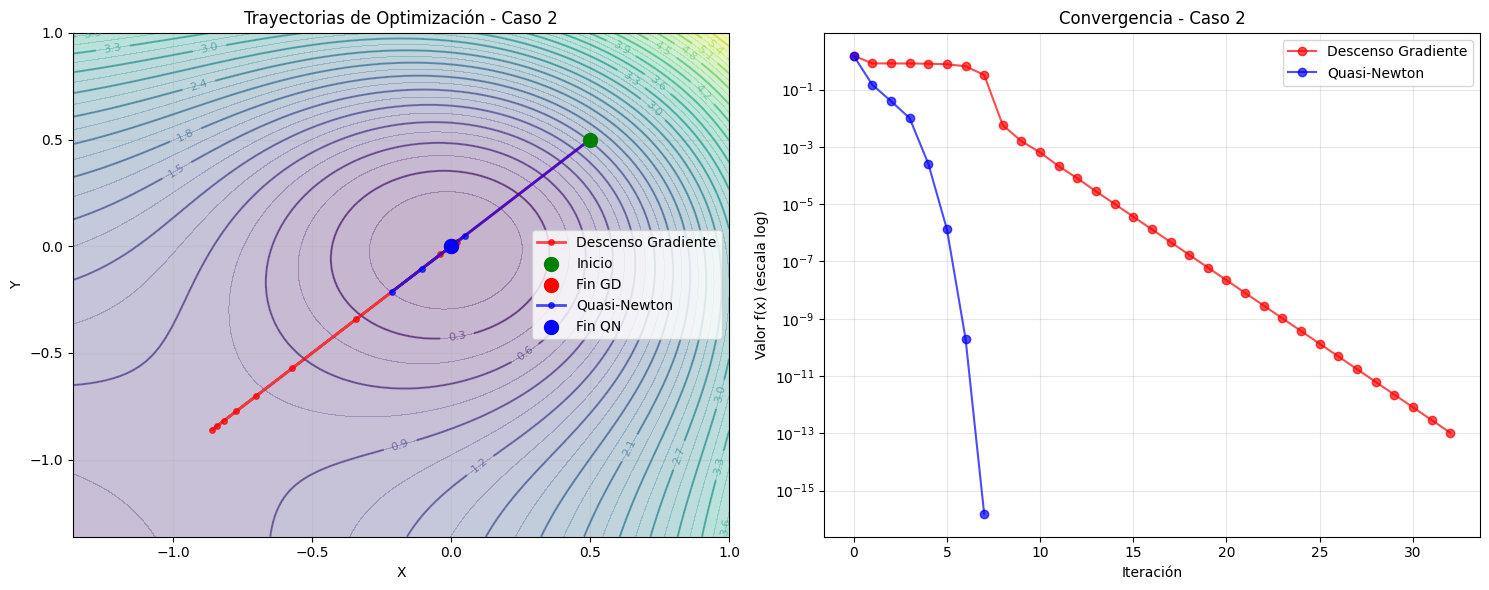

   📐 Resolución 3D: 80x80 para rango X: 2.36, Y: 2.36


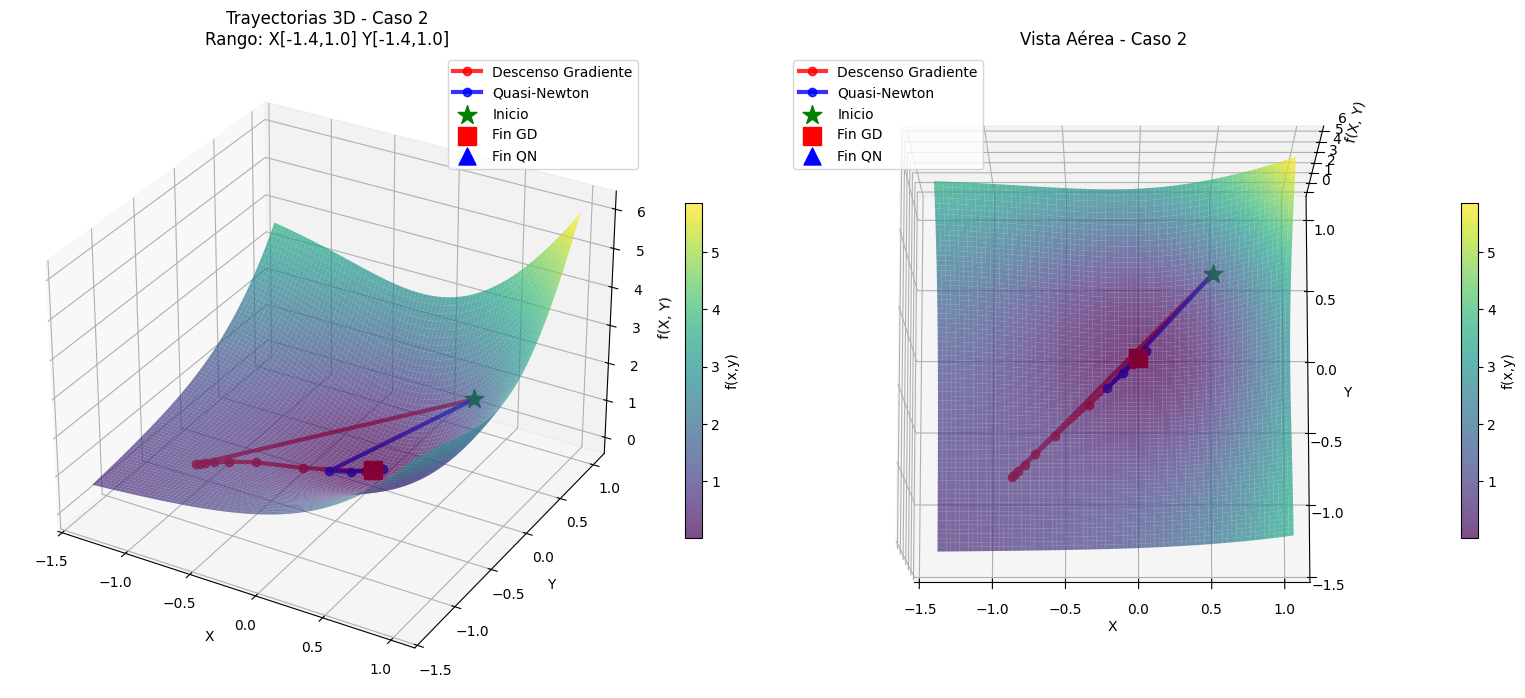


✅ RESULTADOS GUARDADOS EXITOSAMENTE
Archivo: resultados_experimentos.json

📈 GENERANDO GRÁFICOS COMPARATIVOS FINALES...


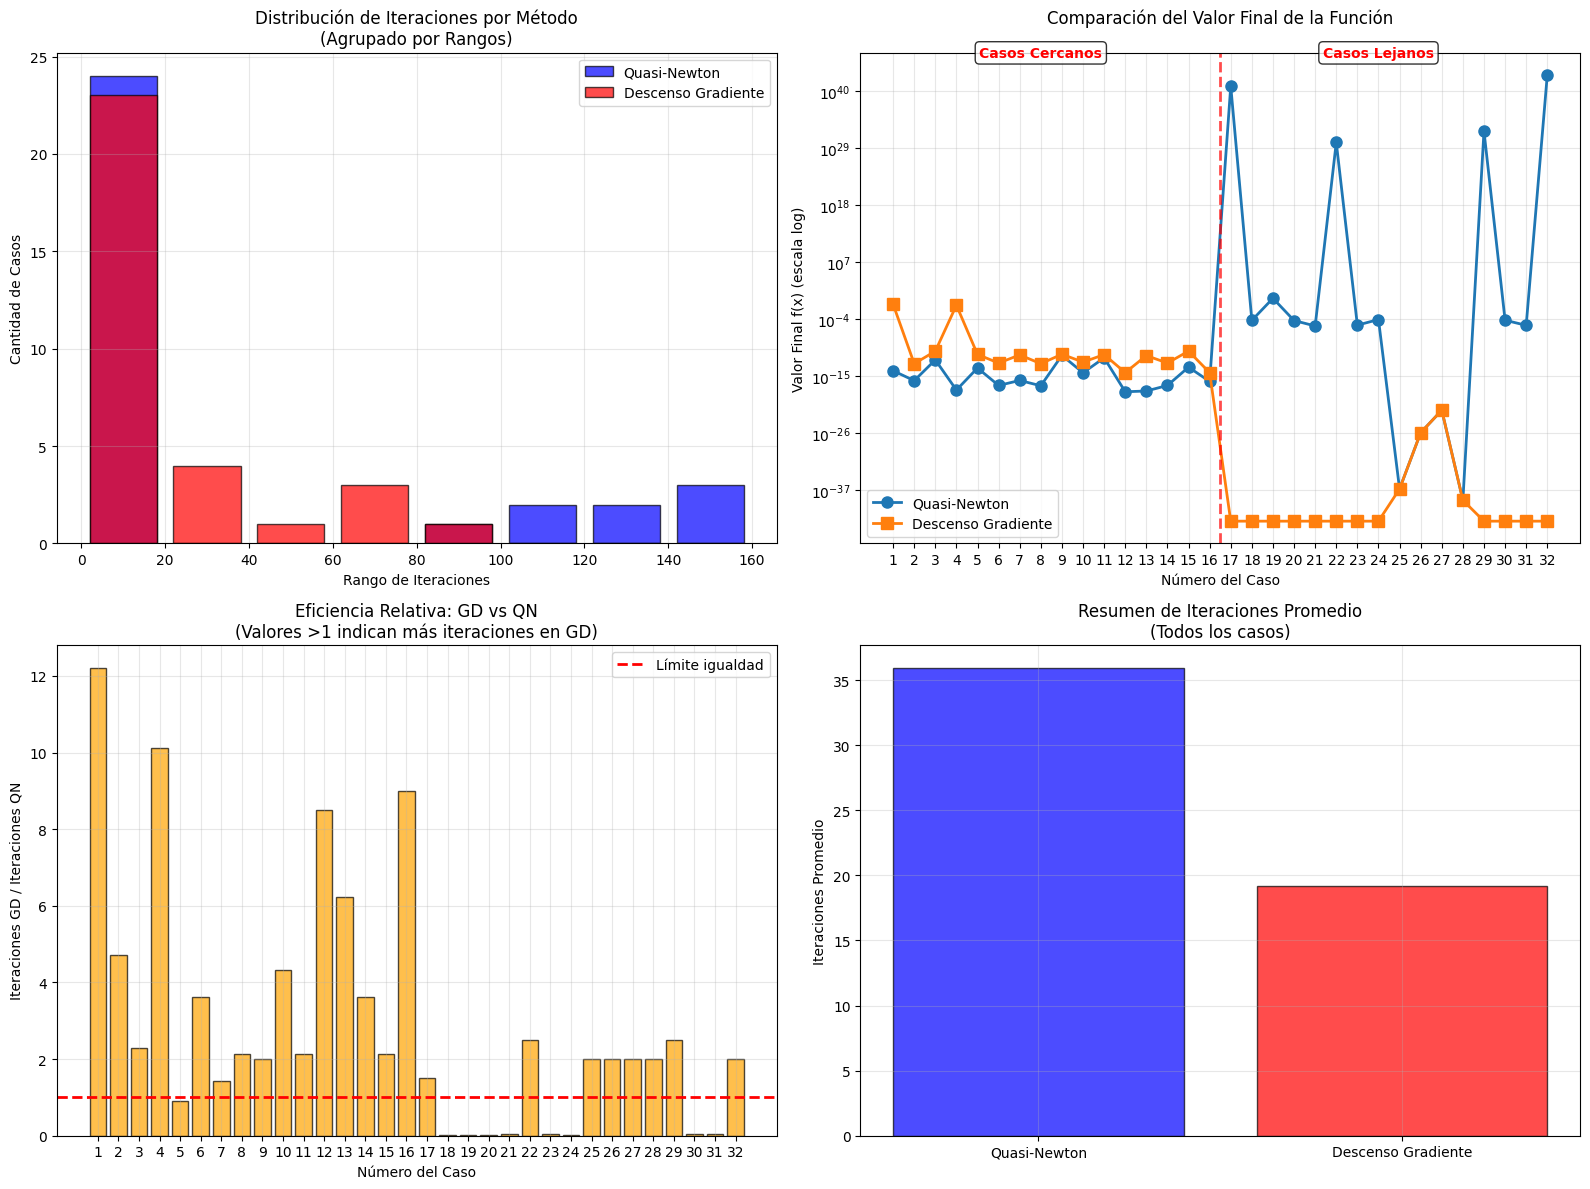

({'metadata': {'fecha_ejecucion': '2025-11-12T13:43:46.677584',
   'total_casos': 32,
   'funcion_objetivo': 'f(x,y) = (eˣ + eʸ) arctan(x² + y²)'},
  'resultados': [{'nombre': 'Cerca-Cuadrante-I',
    'punto_inicial': [0.8, 0.6],
    'parametros': {'learning_rate': 0.4,
     'tolerance': 1e-06,
     'max_iterations': 60},
    'quasi_newton': {'optimo': [-5.262604854627164e-08,
      -5.9331192959757864e-08],
     'iteraciones': 5,
     'valor_final': 1.2579382183068638e-14},
    'descenso_gradiente': {'optimo': [-3.5897484746434216, -3.582197008465402],
     'iteraciones': 61,
     'valor_final': 0.08489942886689761}},
   {'nombre': 'Cerca-Cuadrante-I-2',
    'punto_inicial': [0.5, 0.5],
    'parametros': {'learning_rate': 0.4,
     'tolerance': 1e-06,
     'max_iterations': 60},
    'quasi_newton': {'optimo': [-6.209931892336255e-09,
      -6.2099434766434445e-09],
     'iteraciones': 7,
     'valor_final': 1.5425330322321943e-16},
    'descenso_gradiente': {'optimo': [2.7006076359606

In [84]:
ejecutar_experimentos("casos_prueba.json")